# Reinforcement learning self project : training a agent to play Mario !

## --> Using a Double Deep Q Network


#### Made by : Jérôme Dauba, MS IA, Telecom Paris

-----

Here is the best result achieved by the agent :

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Best Mario Agent :


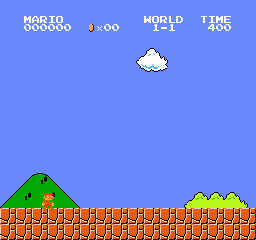

In [ ]:
from IPython.display import Image
from google.colab import drive
drive.mount('/content/drive')
print("\n Best Mario Agent :")
Image(open('/content/drive/MyDrive/Reinforcement Learning/Mario/mario_1-1_WINB_c.gif','rb').read())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install gym-super-mario-bros==7.3.0

import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

     |████████████████████████████████| 204kB 13.2MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.6-cp37-cp37m-linux_x86_64.whl size=436825 sha256=e4235c46994623d2dbe4020a67311fe8ba09991f3a17eadaed61b86581eada0a
  Stored in directory: /root/.cache/pip/wheels/a7/56/af/b84114d31ea6301a5c4651fb048bd6072646596a6ceb3bbc24
Successfully built nes-py
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import math
import random
import matplotlib
from collections import namedtuple
from itertools import count
from PIL import Image
import seaborn as sns
import tqdm
!apt update
!apt install xvfb
!pip install pyvirtualdisplay
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

# Environment Init :

In [ ]:
# Initialize Super Mario environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


# Environment Preprocessing

In [ ]:
import gym
import torch
import random, datetime, numpy as np
from skimage import transform

from gym.spaces import Box

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        resize_obs = transform.resize(observation, self.shape)
        # cast float back to uint8
        resize_obs *= 255
        resize_obs = resize_obs.astype(np.uint8)
        return resize_obs


class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

# Agent Mario

In [ ]:
class Mario:
    def __init__(self, state_dim, action_dim, save_dir, checkpoint):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        # Mario's DNN to predict the most optimal action - we implement this in the Learn section
        self.net = MarioNet(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")
        if checkpoint:
            self.load(checkpoint)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(LazyFrame): A single observation of the current state, dimension is (state_dim)
    Outputs:
    action_idx (int): An integer representing which action Mario will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

In [ ]:
class Mario(Mario):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir, checkpoint):
        super().__init__(state_dim, action_dim, save_dir, checkpoint)
        self.memory = deque(maxlen=100000)
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, checkpoint):
        super().__init__(state_dim, action_dim, save_dir, checkpoint)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, checkpoint):
        super().__init__(state_dim, action_dim, save_dir, checkpoint)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())
        
    def load(self, load_path):
        if not load_path.exists():
            raise ValueError(f"{load_path} does not exist")

        ckp = torch.load(load_path, map_location=('cuda' if self.use_cuda else 'cpu'))
        exploration_rate = ckp.get('exploration_rate')
        state_dict = ckp.get('model')

        print(f"Loading model at {load_path} with exploration rate {exploration_rate}")
        self.net.load_state_dict(state_dict)
        self.exploration_rate = exploration_rate

In [ ]:
class Mario(Mario):
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

In [ ]:
class Mario(Mario):
    def __init__(self, state_dim, action_dim, save_dir, checkpoint):
        super().__init__(state_dim, action_dim, save_dir, checkpoint)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

# Mario Net

In [ ]:
class MarioNet(nn.Module):
    """mini cnn structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        # if h != 84:
        #     raise ValueError(f"Expecting input height: 84, got: {h}")
        # if w != 84:
        #     raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        input = input.float()
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

#Logging

In [ ]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

# Let's learn !

In [ ]:
from tqdm.notebook import tqdm
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 40000
for e in tqdm(range(episodes)):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)

#Let's Play !

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1000, 1000))
display.start()

In [ ]:
import random, datetime
from pathlib import Path
import cv2

!pip install imageio
import imageio

import gym
import gym_super_mario_bros
from gym.wrappers import FrameStack, GrayScaleObservation, TransformObservation
from nes_py.wrappers import JoypadSpace

env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
# env = gym_super_mario_bros.make('SuperMarioBros-1-2-v0')
# env = gym_super_mario_bros.make('SuperMarioBros-1-4-v0')
# env = gym_super_mario_bros.make('SuperMarioBros-2-1-v0')
# env = gym_super_mario_bros.make('SuperMarioBros-1-3-v0')

env = JoypadSpace(
    env,
    [['right'],
    ['right', 'A']]
)

env.reset()

env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env, keep_dim=False)
env = ResizeObservation(env, shape=84)
env = TransformObservation(env, f=lambda x: x / 255.)
env = FrameStack(env, num_stack=4)

save_dir = Path('checkpoints') / datetime.datetime.now().strftime('%Y-%m-%dT%H-%M-%S')
save_dir.mkdir(parents=True)


checkpoint = Path('/content/trained_mario.chkpt')
mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir, checkpoint=checkpoint)
mario.exploration_rate = 0.00 #mario.exploration_rate_min

logger = MetricLogger(save_dir)

episodes = 20

# result = cv2.VideoWriter('./mario_video.avi',  
#                          cv2.VideoWriter_fourcc(*'MJPG'), 
#                          episodes, (256,256))

liste_video_tot = []
liste_steps = []
liste_rewards = []
for e in range(episodes):
    print(f"épisode {e}")
    liste_video_ind = []

    state = env.reset()
    i=0
    R = 0
    while True:
      with torch.no_grad():
        i+=1
        screen = env.render(mode='rgb_array')
        screen2 = np.copy(screen)

        # result.write(screen2)

        # plt.imshow(screen)
        liste_video_ind.append(screen2)
        # ipythondisplay.clear_output(wait=True)
        # ipythondisplay.display(plt.gcf())

        action = mario.act(state)

        next_state, reward, done, info = env.step(action)
        R+=reward
        if info['flag_get'] :
          R+=10000

        mario.cache(state, next_state, action, reward, done)

        logger.log_step(reward, None, None)

        state = next_state

        if done or info['flag_get']:
            liste_steps.append(i)
            liste_rewards.append(R)
            break

    logger.log_episode()
    liste_video_tot.append(liste_video_ind)

    if e % 1 == 0:
        logger.record(
            episode=e,
            epsilon=mario.exploration_rate,
            step=mario.curr_step
        )


liste_len = np.array([len(i) for i in liste_video_ind])
argmax = np.argmax(liste_rewards)
argmax2 = np.argmax(liste_len)
print(liste_rewards, "\n")
print(argmax)
imageio.mimsave('mario.gif', [np.array(img) for img in liste_video_tot[argmax]], fps=13)
# imageio.mimsave('mario2.gif', [np.array(img) for img in liste_video_tot[argmax2]], fps=13)

Loading model at /content/trained_mario.chkpt with exploration rate 0.1
épisode 0


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode 0 - Step 107 - Epsilon 0.1 - Mean Reward 626.0 - Mean Length 107.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 1.906 - Time 2021-04-21T16:37:36
épisode 1
Episode 1 - Step 281 - Epsilon 0.1 - Mean Reward 831.5 - Mean Length 140.5 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 4.238 - Time 2021-04-21T16:37:40
épisode 2
Episode 2 - Step 321 - Epsilon 0.1 - Mean Reward 631.333 - Mean Length 107.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 1.128 - Time 2021-04-21T16:37:41
épisode 3
Episode 3 - Step 524 - Epsilon 0.1 - Mean Reward 660.5 - Mean Length 131.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 4.803 - Time 2021-04-21T16:37:46
épisode 4
Episode 4 - Step 706 - Epsilon 0.1 - Mean Reward 755.0 - Mean Length 141.2 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 4.151 - Time 2021-04-21T16:37:50
épisode 5
Episode 5 - Step 879 - Epsilon 0.1 - Mean Reward 760.667 - Mean Length 146.5 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 3.099 - Time 2021-04-21T16:37:53
épisode 6


<Figure size 432x288 with 0 Axes>